In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyiast as iast
import numpy as np
import ternary as tern
import math
import numdifftools as ndt

Cory's build to enable cubic interp


# load gas adsorption data

define set of MOFs and gases.

In [2]:
mofs = ["HKUST-1"]

gases = ["CH4", 
          "N2", 
         "CO2", 
         "C2H6"
        ]

In [3]:
xtal_density = {"MgMOF74" : 914.87, "HKUST-1": 879.1} # kg/m^3. see compute_density.jl

mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009, "C2H6" : 30.07} # g/mol

gas_to_color = dict(zip(gases, ["C{0}".format(i) for i in range(len(gases))]))

read in `.csv` files containing experimental adsorption data from the literature. see the header of the `.csv` for the data source.

In [4]:
isotherm_data = dict()
for mof in mofs:
    isotherm_data[mof] = dict()
    for gas in gases:
        isotherm_data[mof][gas] = pd.read_csv(gas + "_" + mof + ".csv", comment='#')

unit conversions. goal:
* loading: mmol gas / g MOF [keep it in mmol for IAST!]
* pressure: bar

In [5]:
# special cases for each MOF
isotherm_data["HKUST-1"]["N2"]["p(bar)"] = isotherm_data["HKUST-1"]["N2"]["p(MPa)"] * 10

# where both MOFs need the treatment
for mof in mofs:
    # cm3 STP  *  L STP      *   mol        * 1000mmol
    #  g      1000 cm3 STP    22.4 L STP       1 mol
    isotherm_data[mof]["CH4"]["N(mmol/g)"] = isotherm_data[mof]["CH4"]["cm3/g"] / 22.4

    isotherm_data[mof]["C2H6"]["p(bar)"] = isotherm_data[mof]["C2H6"]["P(mmHg)"] / 750.062
    # cm3 STP  *  L STP      *   mol      * 1000mmol *    m3 MOF    *   kg      * (100^3) cm3 MOF
    # cm3 MOF  1000 cm3 STP   22.4 L STP     1 mol      ρ_MOF kg      1000 g         m3 MOF
    isotherm_data[mof]["C2H6"]["N(mmol/g)"] = isotherm_data[mof]["C2H6"]["N(cm3STP_cm3)"] * 100 ** 3 / 1000 / 22.4 / xtal_density[mof]
    
# check for success
for mof in mofs:
    for gas in gases:
        try:
            isotherm_data[mof][gas]["N(mmol/g)"]
        except KeyError:
            print("failed unit conversion! mof = ", mof, "gas = ", gas)

plot raw data

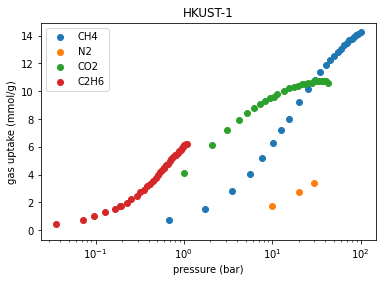

In [6]:
for mof in mofs:
    plt.figure()
    plt.xlabel("pressure (bar)")
    plt.ylabel("gas uptake (mmol/g)")
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker='o', label=gas, color=gas_to_color[gas])
    plt.xscale("log")
    plt.title(mof)
    plt.legend()

# fit isotherm models to data for IAST

In [7]:
isotherms = dict()
for mof in mofs:
    isotherms[mof] = dict()
    for gas in gases:
        model = "Langmuir"
        isotherms[mof][gas] = iast.ModelIsotherm(isotherm_data[mof][gas], 
                                                 loading_key="N(mmol/g)", pressure_key="p(bar)", model=model)

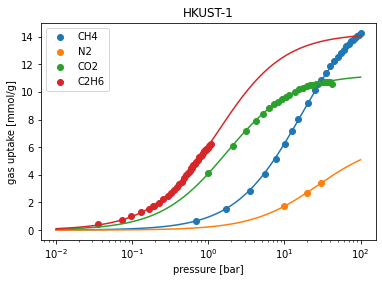

In [8]:
for mof in mofs:
    pressures = np.logspace(-2, 2, 500)
    
    plt.figure()
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker='o', label=gas, color=gas_to_color[gas])
        plt.plot(pressures, isotherms[mof][gas].loading(pressures))
    plt.xscale("log")
    plt.xlabel("pressure [bar]")
    plt.ylabel("gas uptake [mmol/g]")
    plt.title(mof)
    plt.legend()

# set up single-MOF IAST calculations
to obtain $m(\mathbf{x})$, the total mass adsorbed in a given MOF with composition at pressure $\mathbf{x}$.

In [9]:
p_total = 1.0 # total pressure [bar]

In [10]:
"""
compute *total* mass of adsorbed gas in the MOF.
returns units: g gas / g MOF

# example:
mol_fxns = {'C2H6': 0.4, 'CH4': 0.6}
adsorbed_mass("HKUST-1", mol_fxns)
"""
def adsorbed_mass(mof, mol_fxns):
    # mol fractions must add to 1.0
    if ~ np.isclose(np.sum([x_i for x_i in mol_fxns.values()]), 1.0):
        raise Exception("mol fxns dont add to 1")
    
    pressures = np.array([p_total * x_i for x_i in mol_fxns.values()])
    
    q = iast.iast(pressures, [isotherms[mof][gas] for gas in mol_fxns.keys()], warningoff=True)
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    return np.sum([q[j] * mol_wts[gas] for j, gas in enumerate(mol_fxns.keys())]) / 1000

# a single-MOF sensor

In [11]:
mof = "HKUST-1"
contaminants = ["C2H6", "CO2"]

In [12]:
"""
convert mol fraction vector with contaminant mole fractions into a mol_fxn dictionary.
"""
def x_to_mol_fxns(x):
    assert len(x) == len(contaminants)
    mol_fxns = dict()
    mol_fxns["CH4"] = 1.0 - np.sum(x)
    for i, contaminant in enumerate(contaminants):
        mol_fxns[contaminant] = x[i]
    return mol_fxns

"""
convert mole fraction dict to x
"""
def mol_fxns_to_x(mol_fxns):
    return np.array([mol_fxns[contaminant] for contaminant in contaminants])

create heapmap to visualize $m(\mathbf{x})$

In [14]:
delta = 0.005
x_1 = np.arange(0.01, 0.3, delta)
x_2 = np.arange(0.01, 0.3, delta)
X_1, X_2 = np.meshgrid(x_1, x_2)
M = np.zeros(np.shape(X_1))
for i in range(np.shape(X_1)[0]):
    for j in range(np.shape(X_2)[1]):
        mol_fxns = x_to_mol_fxns([x_1[i], x_2[j]])
        M[j, i] = adsorbed_mass(mof, mol_fxns)

define operating point about which to linearize, compute adsorbed mass at the operating point.

In [20]:
mol_fxns_op = {"CH4": 0.85, contaminants[0]: 0.05, contaminants[1]: 0.1}
mol_fxns_op

{'CH4': 0.85, 'C2H6': 0.05, 'CO2': 0.1}

In [23]:
x_op = mol_fxns_to_x(mol_fxns_op)
x_op

array([0.05, 0.1 ])

In [21]:
m_op = adsorbed_mass(mof, mol_fxns_op)
m_op

0.0503879843193028

compute Jacobian matrix of $m(\mathbf{x})$.

In [24]:
def jacobian_matrix_of_m(mof, mol_fxns):
    # complicated b/c adsorbed mass takes in a dictionary.
    # construct J(x)
    J = ndt.Jacobian(lambda x: adsorbed_mass(mof, x_to_mol_fxns(x)), step=0.001)
    
    # compute x for given mole fractions
    x = mol_fxns_to_x(mol_fxns)
    return J(x)

# Jacobian at operating point
J_op = jacobian_matrix_of_m(mof, mol_fxns_op)

# right singular vectors
v1, v2 = np.linalg.svd(J_op)[2]

(0.01, 0.295, 0.01, 0.295)

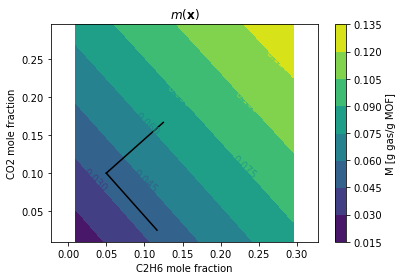

In [27]:
fig, ax = plt.subplots()
CS = ax.contourf(X_1, X_2, M)
plt.colorbar(CS, label="M [g gas/g MOF]")
ax.clabel(CS, inline=True)
ax.set_title("$m(\mathbf{x})$")
ax.set_xlabel(contaminants[0] + " mole fraction")
ax.set_ylabel(contaminants[1] + " mole fraction")
plt.plot([x_op[0], x_op[0] - v1[0]/10], [x_op[1], x_op[1] - v1[1]/10], color='k')
plt.plot([x_op[0], x_op[0] - v2[0]/10], [x_op[1], x_op[1] - v2[1]/10], color='k')
plt.axis("equal")

In [ ]:
def V(x, y, z):
    x, y, z = x[0][0], y[0][0], z[0][0]
    print(x, y, z)
    if x + y + z <= 1:
        return adsorbed_mass([1 - x - y - z, x, y, z])
    else:
        return NaN

In [ ]:
X, Y, Z = np.mgrid[0.001:0.003:0.999, 0.001:0.003:0.999, 0.001:0.003:0.999]
X, Y, Z

In [ ]:
V(X, Y, Z)

In [ ]:
from mayavi import mlab
mlab.contour3d(X, Y, Z, V)

In [ ]:
figure, tax = tern.figure(scale=100)
tax.heatmapf(adsorbed_mass, boundary=False, style="hexagonal")
tax.gridlines(multiple=10)
tax.ticks(multiple=10)
tax.set_title("Heatmap")
tax.left_axis_label(gases[2])
tax.right_axis_label(gases[1])
tax.bottom_axis_label(gases[0])

In [ ]:
# near-pure CH4
adsorbed_mass([0.99,0.005,0.005])

In [ ]:
# near-pure N2
adsorbed_mass([0.005, 0.99, 0.005])

In [ ]:
# near-pure CO2
adsorbed_mass([0.005,0.005,0.99])

In [ ]:
figure, tax = tern.figure(scale=100)
tax.scatter([[1,0,0]])
tax.ticks(multiple=25)

In [ ]:
plt.figure()
plt.plot(x_ch4, m_ads)
plt.ylim(ymin=0)
plt.xlabel("Fraction of CH4")
plt.ylabel("Total Adsorbed Mass (g/g)")
plt.title("Calibration Curve")